In [34]:
from typing import Tuple
import yaml
import os.path as osp

import igl
import trimesh
import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
from pytorch3d.ops import cot_laplacian

from preprocess import mesh_sampling_method
from dataset import MeshData
from models import VAE_coma


In [35]:
config_path = 'config/general_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# set the device, we can just assume we are using single GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = config["dataset"]
template = config["template"]
data_dir = osp.join('data', dataset)
template_fp = osp.join('template', template)

# get the up/down sampling matrix
ds_factor = config["ds_factor"]
edge_index_list, down_transform_list, up_transform_list = mesh_sampling_method(data_fp=data_dir,
                                                                                template_fp=template_fp,
                                                                                ds_factors=ds_factor,
                                                                                device=device)

# create the model
in_channels = config["model"]["in_channels"]
out_channels = config["model"]["out_channels"]
latent_channels = config["model"]["latent_channels"]
K = config["model"]["K"]

model = VAE_coma(in_channels = in_channels,
                out_channels = out_channels,
                latent_channels = latent_channels,
                edge_index = edge_index_list,
                down_transform = down_transform_list,
                up_transform = up_transform_list,
                K=K).to(device)

# get the mean and std of the CAESAR dataset(Traing set)
CAESAR_meshdata = MeshData(root=data_dir, template_fp=template_fp)
# of shape (10002, 3). is torch.Tensor
mean = CAESAR_meshdata.mean
std = CAESAR_meshdata.std

# load the template mesh
template_v, template_f = igl.read_triangle_mesh(template_fp)

# convert it into float32
# as in cot_laplacian, it only supports toch.float32. inv_areas = torch.zeros(V, dtype=torch.float32, device=verts.device)
template_v = template_v.astype('float32')
# convert it into a list of pytorch Tensor.
template_v = torch.from_numpy(template_v).cuda()
template_f = torch.from_numpy(template_f).cuda()

Normalizing the training and testing dataset...
Normalization Done!


# Decoder function 

In [36]:
def decode_func(x, model):
    num_layers = len(model.de_layers)
    num_deblocks = num_layers - 2
    for i, layer in enumerate(model.de_layers):
        if i == 0:
            x = layer(x)
            x = x.view(-1, model.num_vert, model.out_channels[-1])
        elif i != num_layers - 1:
            x = layer(x, model.edge_index[num_deblocks - i],
                        model.up_transform[num_deblocks - i])
        else:
            # last layer
            x = layer(x, model.edge_index[0])
    return x 

# The Laplacian function to compute the Laplacian for each mesh

In [37]:
def laplacian(vertex: torch.Tensor, faces: torch.Tensor, type: str) -> torch.Tensor:
    """
    Compute the laplacian of a mesh.
    Args:
        vertex: FloatTensor of shape (V, 3) giving vertex positions for V vertices.
        faces: LongTensor of shape (F, 3) giving faces.
        type: String giving the type of laplacian to compute. Must be either 'mean' or 'vertex'.
              mean: compute the mean laplacian value for all vertices.
              vertex: compute the laplacian value for each vertex.
    Returns:
        laplacian: FloatTensor of shape (V, 1) giving the laplacian matrix for the mesh.
                   OR, retuen the mean laplacian value for all vertices.
    """
    if type not in ['mean', 'vertex', 'vector']:
        raise ValueError('type must be one of mean, vertex or vector')

    # Compute the cotangent weights.
    L, inv_areas = cot_laplacian(vertex, faces)

    # NOTE: The diagonal entries of the cotangent weights matrix returned by the method are 0
    #       and need to be computed with the negative sum of the weights in each row.
    L_sum = torch.sparse.sum(L, dim=1).to_dense().view(-1, 1)

    # As shown in my thesis, the laplacian is given by: L_loss = L * M^{-1} * V, 
    # However, since the diagonal is zero, we modify it like: L_loss = (L - L_sum) * M^{-1} * V, 
    # where L is the cotangent weights matrix, 
    #       M is the mass matrix, with diagonal entries being 1/3 areas of the vertices,
    #       V is the vertex positions.
    
    # NOTE: I have no idea where the 0.25 comes from.
    #       In my opinion, it should be the weight should be 1/2 (cot alpha_{ij} + cot beta_{ij}).
    #       So, the coefficient should be 0.5. 
    mass_matrix_inv = 0.25 * inv_areas

    loss = (L.mm(vertex) - L_sum * vertex) * mass_matrix_inv

    laplacian_loss = torch.norm(loss, dim=1)

    if type == 'mean':
        return torch.mean(laplacian_loss)
    elif type == 'vertex':
        return laplacian_loss
    elif type == 'vector':
        return loss


# generate mesh samples with direction

In [38]:
# generate a banch of meshes samples from the latent space
def generate_mesh_samples(model_path: str, sample_vals: list, model, mean, std, template_fp: str, model_name: str):
    """_summary_
        generate meshes from the latent values
        save the meshes to the result folder

    Args:
        model_path (str): the path to the model file
        sample_vals (list): the list of latent values we want to sample
        model (VAE_coma): the model
        mean (torch.Tensor): of shape (10002, 3). The mean of the CAESAR dataset.
        std (torch.Tensor): of shape (10002, 3). The std of the CAESAR dataset.
        template_fp (str): the path to the template mesh
        model_name (str): the name of the model
    """
    
    if model_name not in ['vanilla_vae', 'tc_vae', 'beta_annealing', 'deriv']:
        raise ValueError('model_name must be one of vanilla_vae, tc_vae, beta_annealing, deriv')

    # Compute the Laplacian loss of the template mesh
    # Compute the Laplacian loss of the zeros latent vector

    # load the template mesh
    template_v, template_f = igl.read_triangle_mesh(template_fp)
    # create the template trimesh
    template_trimesh = trimesh.Trimesh(vertices=template_v, faces=template_f)
    # compute the vertex normals
    template_vertex_normals = trimesh.smoothing.get_vertices_normals(template_trimesh)
    # convert it into float32
    # as in cot_laplacian, it only supports toch.float32. inv_areas = torch.zeros(V, dtype=torch.float32, device=verts.device)
    template_v = template_v.astype('float32')
    # convert it into a list of pytorch Tensor.
    template_v = torch.from_numpy(template_v).cuda()
    template_f = torch.from_numpy(template_f).cuda()
    # compute the laplacian loss of the template mesh
    template_laplacian_loss_vector = laplacian(template_v, template_f, 'vector')
    template_laplacian_loss_vector = template_laplacian_loss_vector.cpu().numpy()
    # compute the laplacian loss of the template mesh
    template_laplacian_loss = np.sum(template_laplacian_loss_vector * template_vertex_normals, axis=1)

    
    # move the mean and std to the device
    mean = mean.to(device)
    std = std.to(device)

    # Load the model
    model.load_state_dict(torch.load(model_path))

    # create a zero tensor of shape (1, 8) as mean
    mean_latent = torch.zeros((1, 8)).cuda()
    # decode the mean
    mean_v = decode_func(mean_latent, model)
    # convert to numpy array
    mean_v = mean_v.detach()
    mean_v = mean_v * std + mean
    mean_v = mean_v.reshape(-1, 3)

    # get the laplacian loss of the mean latent vector
    mean_laplacian_loss_vector = laplacian(mean_v, template_f, 'vector')
    mean_laplacian_loss_vector = mean_laplacian_loss_vector.cpu().numpy()

    # create a mesh and use it compute the vertex normals
    mean_trimesh = trimesh.Trimesh(vertices=mean_v.cpu().numpy(), faces=template_f.cpu().numpy())
    mean_vertex_normals = trimesh.smoothing.get_vertices_normals(mean_trimesh)

    # compute the laplacian loss of the template mesh
    mean_laplacian_loss = np.sum(mean_laplacian_loss_vector * mean_vertex_normals, axis=1)

    #
    # Now, we generate the meshes from the latent vectors and compute its laplacian loss
    # 

    latent_vectors = torch.zeros((len(sample_vals) * 8, 8))

    for i in range(8):
        latent_vectors[i * len(sample_vals): (i + 1) * len(sample_vals), i] = torch.Tensor(sample_vals)

    # get the total number of latent vectors
    n = latent_vectors.shape[0]

    for i in tqdm(range(8)):

        for j in range(len(sample_vals)):

            # get the latent vector
            n = i * len(sample_vals) + j

            latent_vector = torch.Tensor(latent_vectors[n]).cuda()

            # decode the latent values
            # of shape (n_samples, 10002, 3)
            v = decode_func(latent_vector, model)
            # convert to numpy array
            v = v.detach()
            # denormalize the vertices
            v = v * std + mean
            v = v.reshape(-1, 3)

            # compute the laplacian loss
            laplacian_loss_vector = laplacian(v, template_f, 'vector')
            laplacian_loss_vector = laplacian_loss_vector.cpu().numpy()
            # move the v to cpu
            v = v.cpu().numpy()

            # move the template_f to cpu
            template_f = template_f.cpu().numpy()
            
            # save the mesh 
            trimeshMesh = trimesh.Trimesh(vertices=v, faces=template_f)
            vertex_normals = trimesh.smoothing.get_vertices_normals(trimeshMesh)
            laplacian_loss = np.sum(laplacian_loss_vector * vertex_normals, axis=1)
            mesh = pv.wrap(trimeshMesh)
            mesh["lap_loss"] = laplacian_loss
            mesh["lap_from_mean"] = laplacian_loss - mean_laplacian_loss
            mesh["lap_from_template"] = laplacian_loss - template_laplacian_loss
            mesh.save(osp.join('result', 'laplacian', model_name, "meshes", "mesh{}{:02d}.vtk".format(i, j)))

            # convert the template_f back to torch.Tensor
            template_f = torch.from_numpy(template_f).cuda()


In [39]:
def get_lap(model_path: str, sample_vals: np.ndarray, mean: torch.Tensor, std: torch.Tensor, faces: torch.Tensor, model):
    """_summary_
        load the model from model_path
        sample several points from the latent space
        for each corresponding mesh, return the laplacian loss(type = 'vertex')

    Args:
        model_path (str): the path to the model file
        sample_vals (np.ndarray): of shape (n_samples, ). We would sample n_samples from the latent space. And use the same vals for all 8 dimensions.
        mean (torch.Tensor): of shape (10002, 3). is torch.Tensor
        std (torch.Tensor): of shape (10002, 3). is torch.Tensor
        faces (torch.Tensor): of shape (10002, 3). The faces of the template mesh.
        model (VAE_coma): the model
    """

    mean = mean.to(device)
    std = std.to(device)
    
    # Load the model
    model_params = torch.load(model_path)
    model.load_state_dict(model_params)

    # Sample from the latent space
    # create a tensor of shape (n_samples, 8)
    lap_vals = np.zeros((10002, sample_vals.shape[0], 8))

    # for each latent dimension
    for i in tqdm(range(8)):
        latent_val = torch.zeros((sample_vals.shape[0], 8))

        latent_val[:, i] = torch.Tensor(sample_vals)
        latent_val = latent_val.to(device) 
        
        # decode the latent values
        # of shape (n_samples, 10002, 3)
        v = decode_func(latent_val, model)

        v = v.detach() 
        v = v * std + mean

        for j in range(sample_vals.shape[0]):
            # get the laplacian loss for each mesh
            laplacian_loss = laplacian(v[j], faces, type='vertex')
            lap_vals[:, j, i] = laplacian_loss.cpu().numpy()

    return lap_vals

# Plot function for plotting result for each latent variable change

In [40]:
# plotting function
# TODO: Change the y-axis limit. The specific value should be determined by the dataset.
def plot_latent(filename: str, sample_vals: np.ndarray, lap_vals: np.ndarray):
    """_summary_
        declare a plot of 8 subplots, 8 rows and 1 column
        each subplot is a dot plot of the corresponding latent dimension
        the x-axis is the latent value, the y-axis is the height
        the figure size is tight to the subplots
    Args:
        filename (str): the file name to save the plot.
        sample_vals (np.ndarray): of shape (n_samples, ). We would sample n_samples from the latent space. And use the same vals for all 8 dimensions.
        lap_vals (np.ndarray): of shape (n_samples, 8). 8 is the number of latent dimensions.
    """

    # Ensure that the dimensions match up correctly
    if len(sample_vals) != lap_vals.shape[0] or lap_vals.shape[1] != 8:
        raise ValueError("Input dimensions are mismatched!")

    fig, axs = plt.subplots(8, 1, figsize=(5, 28), tight_layout=True)

    for i, ax in enumerate(axs):
        # Plot each latent dimension
        ax.scatter(sample_vals, lap_vals[:, i], marker='o')
        
        # set the x-axis limit to be between -1 and 1
        # set the y-axis limit to be between 1.5 and 2
        ax.set_xlim(-1, 1)
        ax.set_ylim(12, 19)
        
        ax.set_title("Latent dimension {}".format(i))

    # Save the figure to the given filename
    plt.savefig(filename)

# The Laplacian Loss on template mesh

The max loss is 416.103
The min loss is -785.334
The median loss is -3.422
The std loss is 25.637


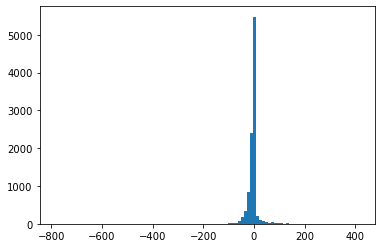

In [41]:
temp_lap_loss_mean = laplacian(template_v, template_f, 'mean')
# print(f"The mean loss is {temp_lap_loss_mean:.3f}")

temp_lap_loss_vertex = laplacian(template_v, template_f, 'vertex')
# print("The max loss is {:.3f}".format(torch.max(temp_lap_loss_vertex).item()))
# print("The median loss is {:.3f}".format(torch.median(temp_lap_loss_vertex).item()))
# print("The std loss is {:.3f}".format(torch.std(temp_lap_loss_vertex).item()))

# plt.hist(temp_lap_loss_vertex .cpu().numpy(), bins=100)

temp_v, temp_f = igl.read_triangle_mesh(template_fp)
temp_mesh = trimesh.Trimesh(vertices=temp_v, faces=temp_f)
vertex_normals = trimesh.smoothing.get_vertices_normals(temp_mesh)
temp_lap_loss_vector = laplacian(template_v, template_f, 'vector').cpu().numpy()

lap = np.sum(temp_lap_loss_vector * vertex_normals, axis=1)
temp_mesh = pv.wrap(temp_mesh)
temp_mesh["lap_loss"] = lap
temp_mesh.save(osp.join('result', 'laplacian', 'template.vtk'))

plt.hist(lap, bins=100)

print("The max loss is {:.3f}".format(np.max(lap)))
print("The min loss is {:.3f}".format(np.min(lap)))
print("The median loss is {:.3f}".format(np.median(lap)))
print("The std loss is {:.3f}".format(np.std(lap)))


In [42]:
temp_v, temp_f = igl.read_triangle_mesh(template_fp)
temp_mesh = trimesh.Trimesh(vertices=temp_v, faces=temp_f)
temp_lap_loss_vertex = laplacian(template_v, template_f, 'vertex').cpu().numpy()

temp_mesh = pv.wrap(temp_mesh)
temp_mesh["lap_loss"] = temp_lap_loss_vertex
temp_mesh_diff = np.abs(temp_lap_loss_vertex - temp_lap_loss_vertex)
temp_mesh["temp_diff"] = temp_mesh_diff
temp_mesh.save(osp.join('result', 'laplacian', 'template_mean.vtk'))

In [43]:
# model_path = "out/vae_coma/trainer12/20231220-123538/model.pth" # our method
# model_path = "out/vae_coma/trainer13/20240119-003904/model.pth" # our method without Laplacian loss
# model_path = "out/vae_coma/trainer14/20240119-090527/model.pth" # our method without AWL
model_path = "out/vae_coma/trainer15/20240119-193650/model.pth" # our method without disentanglement

model.load_state_dict(torch.load(model_path))

sample_vals = np.linspace(-1, 1, 50)
lap_loss = get_lap(model_path, sample_vals, mean, std, template_f, model)


# write the printed info into a file
with open("result/ablation/laplacian/wo_disentanglement/laplacian.txt", "w") as f:
    print("The mean loss for our method is {:.3f}".format(np.mean(lap_loss)), file=f)
    print("The max loss for our method is {:.3f}".format(np.max(lap_loss)), file=f)
    print("The median loss for our method is {:.3f}".format(np.median(lap_loss)), file=f)
    print("The std loss for our method is {:.3f}".format(np.std(lap_loss)), file=f)

100%|██████████| 8/8 [00:00<00:00,  9.60it/s]


In [44]:
model.load_state_dict(torch.load(model_path))
latent_vector = torch.zeros((1, 8)).cuda()
v = decode_func(latent_vector, model)
# convert to numpy array
v = v.detach().cpu()
# denormalize the vertices
v = v * std + mean
v = v.reshape(-1, 3)

temp_v, temp_f = igl.read_triangle_mesh(template_fp)
our_method_mesh = trimesh.Trimesh(vertices=v, faces=temp_f)
v = v.cuda()
our_method_lap_loss_vertex = laplacian(v, template_f, 'vertex').cpu().numpy()
our_method_lap_loss_diff = np.abs(our_method_lap_loss_vertex - temp_lap_loss_vertex)
our_method_mean_mesh = pv.wrap(our_method_mesh)
our_method_mean_mesh["lap_loss"] = our_method_lap_loss_vertex
our_method_mean_mesh["lap_loss_diff"] = our_method_lap_loss_diff
our_method_mean_mesh.save(osp.join('result', 'ablation', 'laplacian', 'wo_disentanglement', 'mean.vtk'))